# Scrape data from https://www.the-numbers.com/ 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

from bs4 import BeautifulSoup as bs
import requests

In [51]:
pd.set_option("display.max_columns",100)

In [52]:
header = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36","X-Requested-With": "XMLHttpRequest"}

## Import box-office data  

In [53]:
data=pd.DataFrame()
for i in range(0,11):
    url="https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time/"+str(i*100)+"1"
    page = requests.get(url, headers=header)
    df=pd.read_html(page.text)[0]
    data=pd.concat([data,df],ignore_index=True)

In [54]:
data.head()

,Rank,Year,Movie,WorldwideBox Office,DomesticBox Office,InternationalBox Office
0,1,2009,Avatar,"$2,845,899,541","$760,507,625","$2,085,391,916"
1,2,2019,Avengers: Endgame,"$2,797,800,564","$858,373,000","$1,939,427,564"
2,3,1997,Titanic,"$2,207,986,545","$659,363,944","$1,548,622,601"
3,4,2015,Star Wars Ep. VII: The Force Awakens,"$2,064,615,817","$936,662,225","$1,127,953,592"
4,5,2018,Avengers: Infinity War,"$2,048,359,754","$678,815,482","$1,369,544,272"


## Import metrics data for each movie

In [55]:
url="https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time"
page = requests.get(url, headers=header)
soup=bs(page.content,'html.parser')

hrefs=soup.select("div[id='main'] tbody tr td:nth-child(3) a")[:11]
Metrics=pd.DataFrame()
for href in hrefs:
    title=href.text
    url2="https://www.the-numbers.com/"+href["href"]
    page = requests.get(url2,headers=header)
    soup=bs(page.content,'html.parser')
    trs=soup.select("div[id='main'] div[id='desktop_layout'] div[id='summary'] table:nth-child(2) tr")[:6]
    metrics=[]
    for tr in trs:
        metrics.append({
        "Title":href.text,
        "Metric":tr.b.text,
        "Info":tr.select("td:nth-child(2)")[0].text
        })
    df=pd.DataFrame(metrics)
    Metrics=pd.concat([Metrics,df],ignore_index=True)

In [56]:
metrics=Metrics.pivot("Title","Metric","Info").reset_index()

In [57]:
metrics.head()

Metric,Title,Domestic Share:,Infl. Adj. Dom. BO,Legs:,Opening Weekend:,Production Budget:,Theater counts:
0,Avatar,26.7% (domestic box office/worldwide),"$905,165,702",9.87 (domestic box office/biggest weekend),"$77,025,481 (10.1% of total gross)","$237,000,000 (worldwide box office is 12.0 tim...","3,452 opening theaters/3,461 max. theaters, 13..."
1,Avengers: Endgame,30.7% (domestic box office/worldwide),"$859,310,090",2.40 (domestic box office/biggest weekend),"$357,115,007 (41.6% of total gross)","$400,000,000 (worldwide box office is 7.0 time...","4,662 opening theaters/4,662 max. theaters, 8...."
2,Avengers: Infinity War,33.1% (domestic box office/worldwide),"$683,286,273",2.63 (domestic box office/biggest weekend),"$257,698,183 (38.0% of total gross)","$300,000,000 (worldwide box office is 6.8 time...","4,474 opening theaters/4,474 max. theaters, 7...."
3,Frozen II,33.0% (domestic box office/worldwide),"$477,865,316",3.66 (domestic box office/biggest weekend),"$130,263,358 (27.3% of total gross)","$150,000,000 (worldwide box office is 9.6 time...","4,440 opening theaters/4,440 max. theaters, 8...."
4,Furious 7,23.3% (domestic box office/worldwide),"$383,994,584",2.40 (domestic box office/biggest weekend),"$147,163,560 (41.7% of total gross)","$190,000,000 (worldwide box office is 8.0 time...","4,003 opening theaters/4,022 max. theaters, 6...."


# Import daily box-office data  

In [58]:
url="https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time"
page = requests.get(url, headers=header)
soup=bs(page.content,'html.parser')

hrefs=soup.select("div[id='main'] tbody tr td:nth-child(3) a")[:11]
box_office={}
for href in hrefs:
    title=href.text
    url2="https://www.the-numbers.com/"+href["href"].split("#tab=")[0]+"#tab=box-office"
    page = requests.get(url2,headers=header)
    df=pd.read_html(page.text)[8]
    df["Title"]=title
    box_office[title]=df

In [59]:
boxoffice=pd.DataFrame()
for key,value in box_office.items():
    boxoffice=pd.concat([boxoffice,value],ignore_index=True)

In [60]:
boxoffice.head()

,Date,Rank,Gross,%YD,%LW,Theaters,Per Theater,Total Gross,Days,Title
0,"Dec 18, 2009",1,"$26,752,099",NaN,NaN,3452,"$7,750","$26,752,099",1.0,Avatar
1,"Dec 19, 2009",1,"$25,529,036",-5%,NaN,3452,"$7,395","$52,281,135",2.0,Avatar
2,"Dec 20, 2009",1,"$24,744,346",-3%,NaN,3452,"$7,168","$77,025,481",3.0,Avatar
3,"Dec 21, 2009",1,"$16,385,820",-34%,NaN,3452,"$4,747","$93,411,301",4.0,Avatar
4,"Dec 22, 2009",1,"$16,086,461",-2%,NaN,3452,"$4,660","$109,497,762",5.0,Avatar


# Import international data  

In [61]:
url="https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time"
page = requests.get(url, headers=header)
soup=bs(page.content,'html.parser')

hrefs=soup.select("div[id='main'] tbody tr td:nth-child(3) a")[:11]
International={}
for href in hrefs:
    title=href.text
    url2="https://www.the-numbers.com/"+href["href"].split("#tab=")[0]+"#tab=international"
    page = requests.get(url2,headers=header)
    df=pd.read_html(page.text)[10]
    df["Title"]=title
    International[title]=df

In [62]:
international=pd.DataFrame()
for key,value in International.items():
    international=pd.concat([international,value],ignore_index=True)


In [63]:
international=international[international.Territory!="International Total"]

In [64]:
international.head()

,Territory,ReleaseDate,OpeningWeekend,OpeningWeekendScreens,MaximumScreens,TheatricalEngagements,TotalBox Office,ReportDate,Title
0,Argentina,1/1/2010,$0,0,0,0,"$1,851,813",1/1/2019,Avatar
1,Australia,12/17/2009,"$10,630,171",588,590,3142,"$76,623,609",2/25/2020,Avatar
2,China,3/11/2021,"$20,970,000",89569,89569,220834,"$265,020,000",5/3/2021,Avatar
3,Italy,9/22/2022,$0,0,0,0,$0,NaN,Avatar
4,New Zealand,12/17/2009,$0,0,1,1,$92,8/24/2020,Avatar


# Success! Data is imported!

# Clean and plot data

In [65]:
data.columns = data.columns.str.strip()
data["WorldwideBox Office"]=data["WorldwideBox Office"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
data["DomesticBox Office"]=data["DomesticBox Office"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
data["InternationalBox Office"]=data["InternationalBox Office"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)

## how was average box office changing in value over time  

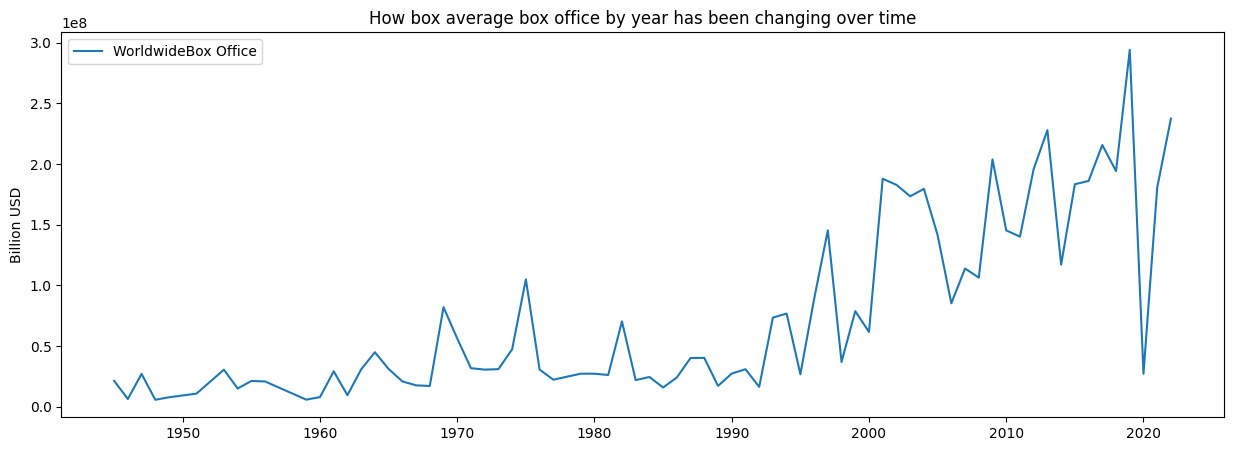

In [66]:
grouped=data.groupby("Year").agg({"WorldwideBox Office":"mean","DomesticBox Office":"mean","InternationalBox Office":"mean"}).reset_index()
grouped=grouped.sort_values("Year")

grouped.plot(figsize=(15,5),kind="line",x="Year",y=grouped.columns[1],legend=True,xlabel="",ylabel="Billion USD")
plt.title("How box average box office by year has been changing over time")
plt.show()

### metrics 

In [67]:
metrics.columns=metrics.columns.str.strip().str.replace(":","")

metrics["Domestic Share"]=metrics["Domestic Share"].str.split(" ").str[0]
metrics["Infl. Adj. Dom. BO"]=metrics["Infl. Adj. Dom. BO"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
metrics["Legs"]=metrics["Legs"].str.split(" ").str[0].astype(float)
# metrics.columns.tolist() to find out the reason why pandas can't read the column name 
metrics["Opening\xa0Weekend"]=metrics["Opening\xa0Weekend"].str.split(" ").str[0].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
metrics["Production\xa0Budget"]=metrics["Production\xa0Budget"].str.split(" ").str[0].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
metrics["Theater counts"]=metrics["Theater counts"].str.split(" ").str[0].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)

## Is there any correlation between theater count and opening weekend income

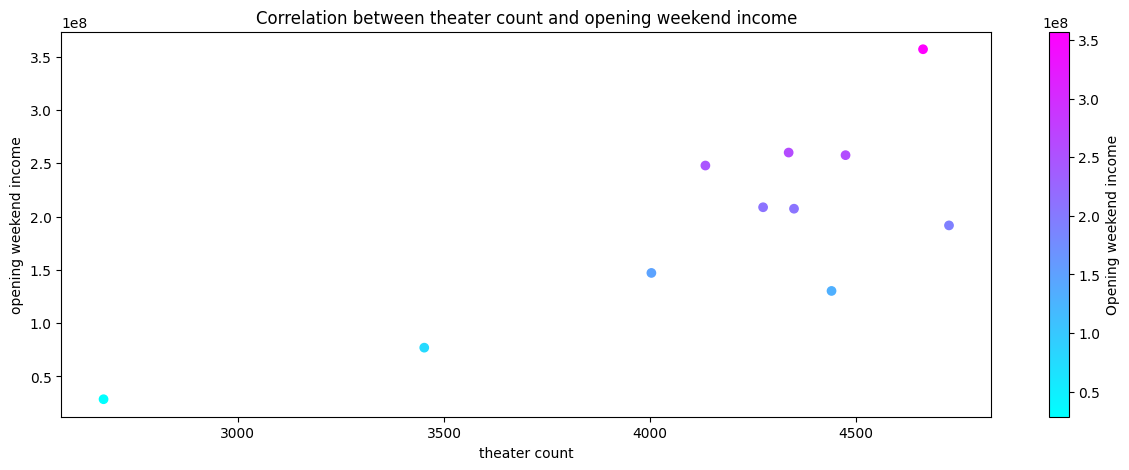

correaltion coefficient is :  0.78


In [74]:
plt.figure(figsize=(15,5))
plt.scatter(metrics["Theater counts"],metrics["Opening\xa0Weekend"],c=metrics["Opening\xa0Weekend"],cmap="cool")
plt.colorbar().set_label("Opening weekend income")
plt.title("Correlation between theater count and opening weekend income")
plt.xlabel("theater count")
plt.ylabel("opening weekend income")
plt.show()

print("correaltion coefficient is : ",round(metrics["Theater counts"].corr(metrics["Opening\xa0Weekend"]),2) )

### daily box-office 

## How daily gross income was flactuating over period for each movie 

In [69]:
boxoffice["Date"]=pd.to_datetime(boxoffice["Date"])
boxoffice["Gross"]=boxoffice["Gross"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)

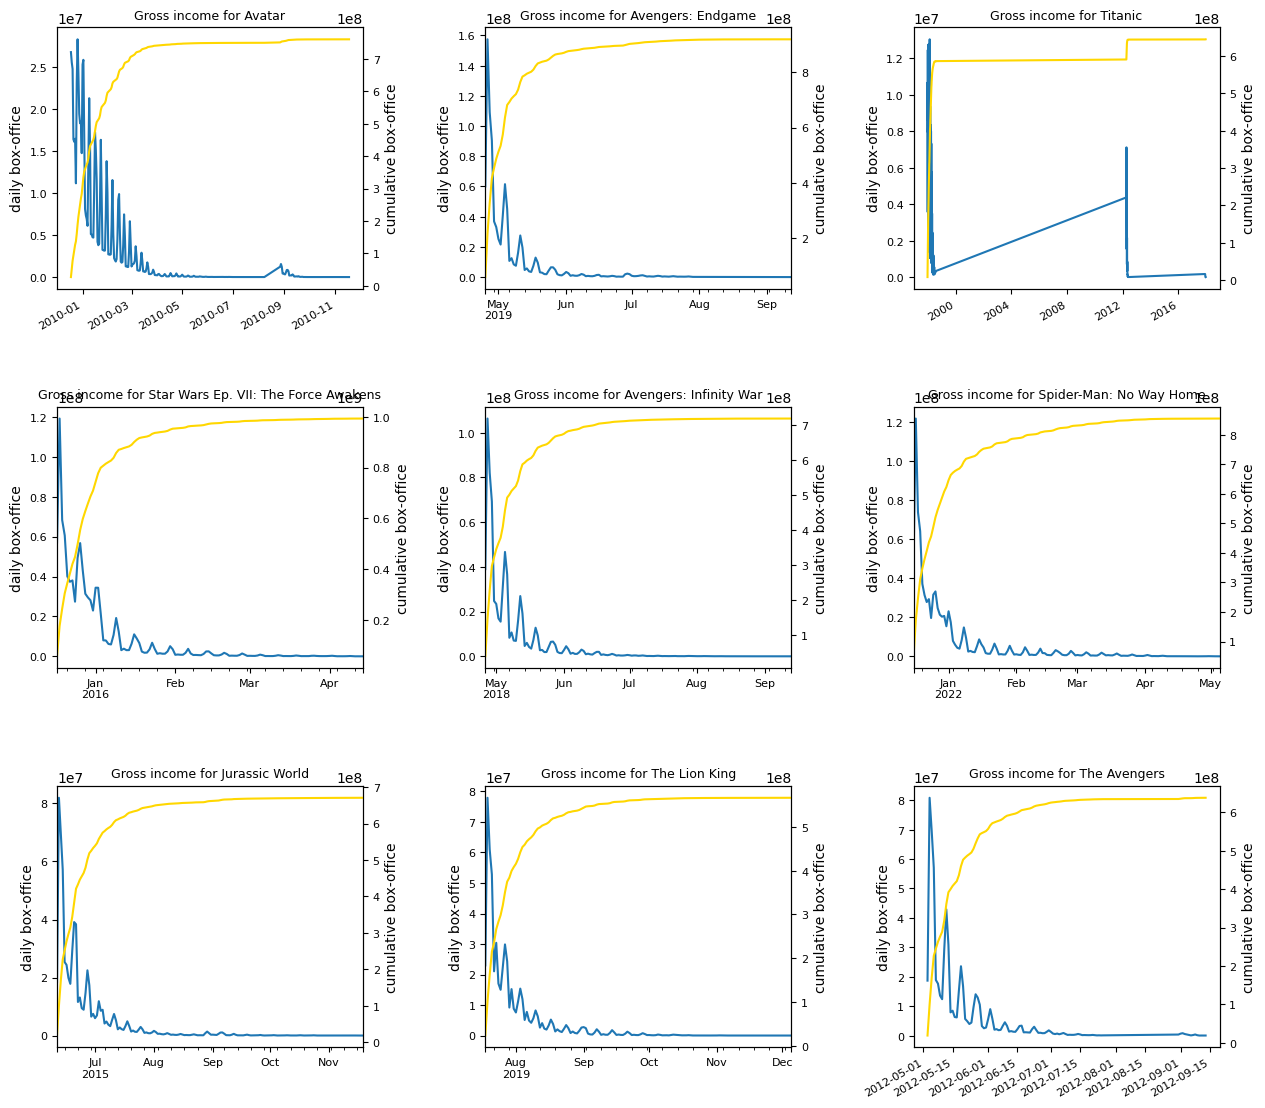

In [70]:
titles=boxoffice.Title.unique()
fig,axes=plt.subplots(3,3,figsize=(15,15))
for t,ax in zip(titles,axes.ravel()):
    filtered=boxoffice[boxoffice.Title==t].sort_values("Date")
    filtered["cumulative"]=filtered.Gross.cumsum()
    filtered.plot(kind="line",ax=ax,x="Date",y="Gross",legend=False,xlabel="",ylabel="daily box-office",fontsize=8)
    ax.set_title("Gross income for "+t,size=9)
    
    ax2=ax.twinx()
    filtered.plot(kind="line",ax=ax2,x="Date",y="cumulative",legend=False,xlabel="",ylabel="cumulative box-office",fontsize=8,color="gold")
    
    plt.subplots_adjust(hspace=0.45,wspace=0.4)
plt.show()  